In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from sklearn.mixture import log_multivariate_normal_density
from IPython.display import Audio
from tools2 import logsumexp
from proto2 import *
from prondict import *

example = np.load('lab2_example.npz')['example'].item()
data = np.load('lab2_data.npz')['data']
phoneHMMs = np.load('lab2_models.npz')['phoneHMMs'].item()
NUM_CLASS = len(prondict)

### Lexical Model

In [3]:
modellist = {}
wordHMMs = {}
for digit in prondict.keys():
    modellist[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs[digit] = concatHMMs(phoneHMMs,modellist[digit],digit)
result = {}

## HMM Likelihood and Recognition

In [4]:
import warnings; warnings.simplefilter('ignore')
digit = 'o'
result['obsloglik'] = log_multivariate_normal_density(example['lmfcc'],wordHMMs[digit]['means'],wordHMMs[digit]['covars'],'diag')
result['logalpha'] = forward(result['obsloglik'],np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
result['vloglik'] = viterbi(result['obsloglik'],np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
result['logbeta'] = backward(result['obsloglik'],np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
result['loggamma'] = statePosteriors(result['logalpha'],result['logbeta'])

print(np.allclose(example['obsloglik'],result['obsloglik']))
print(np.allclose(example['logalpha'],result['logalpha']))
print(example['vloglik'][0] == result['vloglik'][0])
print(np.all(example['vloglik'][1]  == result['vloglik'][1]))
print(np.allclose(example['logbeta'],result['logbeta']))
print(np.allclose(example['loggamma'],result['loggamma']))

True
True
True
True
True
True


### Single Gaussian emission probabilities

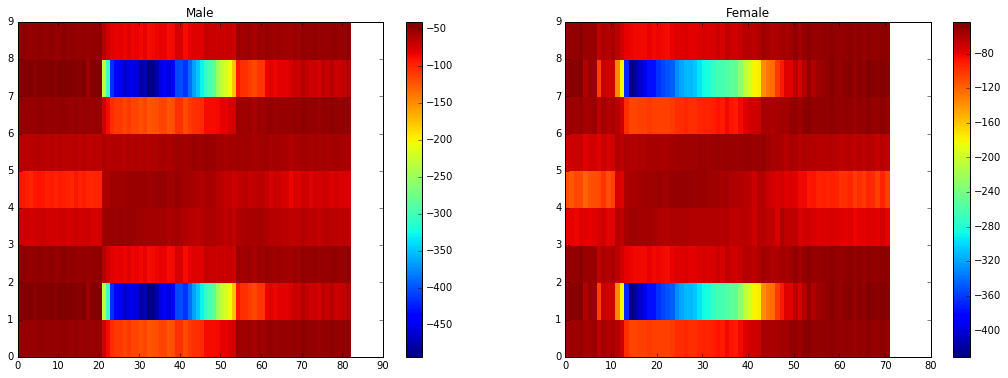

In [5]:
digit = 'o'
q1_1 = log_multivariate_normal_density(data[0]['lmfcc'],wordHMMs[digit]['means'],wordHMMs[digit]['covars'],'diag')
q1_3 = log_multivariate_normal_density(data[22]['lmfcc'],wordHMMs[digit]['means'],wordHMMs[digit]['covars'],'diag')

plt.figure(figsize=(18, 6))
plt.subplot(1,2, 1)
plt.title("Male")
pcolormesh(q1_1.T)
plt.colorbar()

plt.subplot(1,2, 2)
plt.title("Female")
pcolormesh(q1_3.T)
plt.colorbar()

['sil', 's', 'eh', 'v', 'ah', 'n', 'sil']


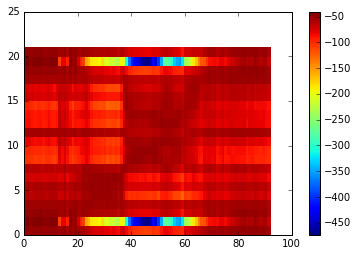

In [6]:
digit = '7'
print(modellist[digit])
q1_2 = log_multivariate_normal_density(data[16]['lmfcc'],wordHMMs[digit]['means'],wordHMMs[digit]['covars'],'diag')
pcolormesh(q1_2.T)
plt.colorbar()

The order is **silence + some phoneme + silence**, and the activated part is gaussian in the beginning and the end, then gaussian in the middle (which also corresponds to the states)，Gaussian in the endpoints matches 'sil'.

Another interesting thing is the state **discrimitiv power** is more obvious between 'sil' and other phoneme than between phonemes (which is intuitive)

### Forward Algorithm

In [49]:
res = np.zeros((len(data),NUM_CLASS))

for i,utt in enumerate(data):
    for j,cl in enumerate(prondict.keys()):
        obsloglik = log_multivariate_normal_density(utt['lmfcc'],wordHMMs[cl]['means'],wordHMMs[cl]['covars'],'diag')
        res[i][j] = logsumexp(forward(obsloglik,np.log(wordHMMs[cl]['startprob']),np.log(wordHMMs[cl]['transmat'][:-1,:-1]))[-1])       
print(np.argmax(res,axis=1))

[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10  0  0
  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10]


$\log \alpha_N(j) = \log P(X,z_n = s_j | \theta)$

$\log \alpha_N(i) = \log P(X,z_n = s_i | \theta)$

$P(X,z_n = s_i \land z_n = s_j | \theta) = 0, \forall i \not = j$

Thus,
<center>$P(X|\theta) = \sum_j^{M-1} \exp(\alpha_N(j))$</center>

Because log function is monotonic increasing, so we can just pick the `argmax` in log domain


### Viterbi Algorithm

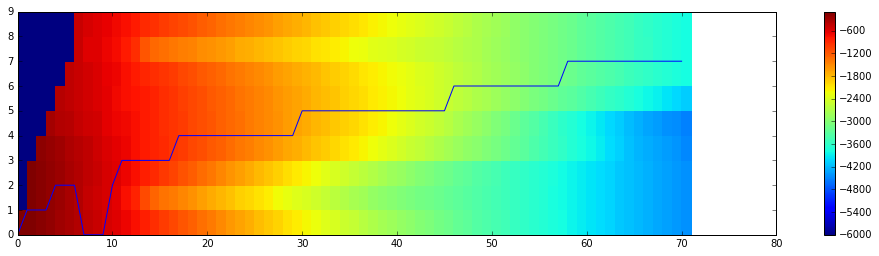

In [50]:
digit = 'o'
obsloglik = log_multivariate_normal_density(example['lmfcc'],wordHMMs[digit]['means'],wordHMMs[digit]['covars'],'diag')
logalpha = forward(obsloglik,np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
_,bestpath = viterbi(obsloglik,np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
plt.figure(figsize=(17, 4))
pcolormesh(logalpha.T)
plot(bestpath)
plt.clim(-6000,-100) # cutoff -inf
plt.colorbar()

In [51]:
resv = np.zeros((len(data),NUM_CLASS))

for i,utt in enumerate(data):
    for j,cl in enumerate(prondict.keys()):
        obsloglik = log_multivariate_normal_density(utt['lmfcc'],wordHMMs[cl]['means'],wordHMMs[cl]['covars'],'diag')
        resv[i][j],_ = viterbi(obsloglik,np.log(wordHMMs[cl]['startprob']),np.log(wordHMMs[cl]['transmat'][:-1,:-1]))
        
np.argmax(resv,axis=1)

array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
        8,  9,  9, 10, 10,  0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,
        6,  6,  7,  7,  8,  8,  9,  9, 10, 10])

In [121]:
all(np.argmax(resv,axis=1) == np.argmax(res,axis=1))

True

Like the previous part, the accuracy is 100%, but runtime of Viterbi algorithm is much faster (although the complexity is the same, $\mathcal{O}(TM^2)$)

### Backward Algorithm

## HMM Retraining

### State posterior probabilities

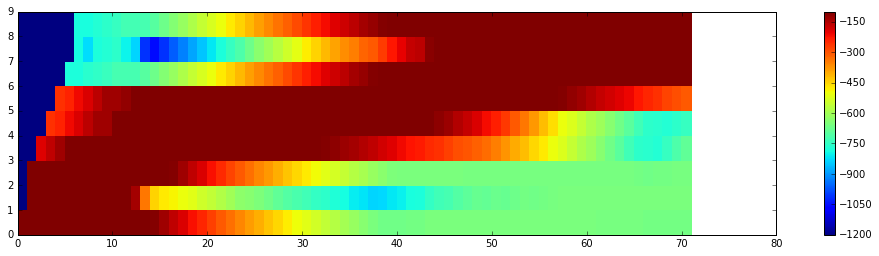

In [6]:
plt.figure(figsize=(17, 4))
pcolormesh(result['loggamma'].T)
plt.clim(-1200,-100) # cutoff -inf
plt.colorbar()

> What is the meaning if we sum the posteriors (in linear domain) for each state along the time axis?

Equal to the $\mathbb{E}$[# visiting times of that state]

> What about summing over both states and time steps (in linear domain)?

Because we already know that in each time step, the summation of posterior probability over states is equal to 1, so this number will **equal to the number of frames**

### Retraining the emission probability distrubutions

[-4355.8518021021555, -3924.9050093224796, -3611.0390471220876, -3566.325509368496, -3560.959674459771, -3558.948118127386, -3556.879622110004]
Number of iterations: 7


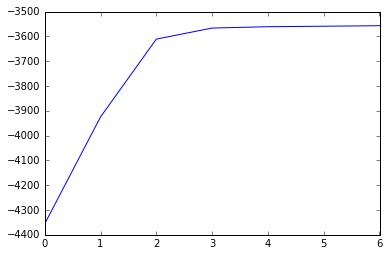

In [7]:
MAX_ITER = 20
EPS = 1.0
digit = '4'

loglik_record = []

for tt in range(MAX_ITER):
    
    ## Expectation
    obsloglik = log_multivariate_normal_density(data[10]['lmfcc'],wordHMMs[digit]['means'],wordHMMs[digit]['covars'],'diag')
    logalpha = forward(obsloglik,np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
    logbeta = backward(obsloglik,np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
    loggamma = statePosteriors(logalpha,logbeta)
    loglik = logsumexp(logalpha[-1])
    
    if tt != 0 and loglik < EPS + loglik_record[-1]:
        break
    loglik_record.append(loglik)
    
    ## Maximization
    wordHMMs[digit]['means'],wordHMMs[digit]['covars'] = updateMeanAndVar(data[10]['lmfcc'],loggamma,wordHMMs[digit]['means'])
    
print(loglik_record)
print("Number of iterations: {}".format(len(loglik_record)))
plot(loglik_record)
    

[-4733.232819331214, -4141.575892699713, -3640.206153238676, -3585.8206900035066, -3571.394559182388]
Number of iterations: 5


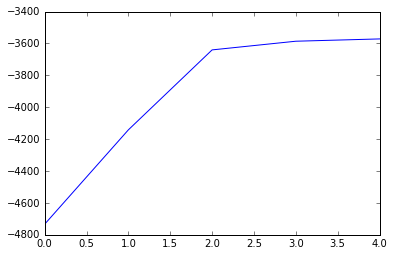

In [57]:
MAX_ITER = 20
EPS = 1.0
digit = '9'

loglik_record = []

for tt in range(MAX_ITER):
    
    ## Expectation
    obsloglik = log_multivariate_normal_density(data[10]['lmfcc'],wordHMMs[digit]['means'],wordHMMs[digit]['covars'],'diag')
    logalpha = forward(obsloglik,np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
    logbeta = backward(obsloglik,np.log(wordHMMs[digit]['startprob']),np.log(wordHMMs[digit]['transmat'][:-1,:-1]))
    loggamma = statePosteriors(logalpha,logbeta)
    loglik = logsumexp(logalpha[-1])
    
    if tt != 0 and loglik < EPS + loglik_record[-1]:
        break
    loglik_record.append(loglik)
    
    ## Maximization
    wordHMMs[digit]['means'],wordHMMs[digit]['covars'] = updateMeanAndVar(data[10]['lmfcc'],loggamma,wordHMMs[digit]['means'])
    
print(loglik_record)
print("Number of iterations: {}".format(len(loglik_record)))
plot(loglik_record)
    